# The classification task: decision trees and K-nearest neighbors
### Master's Degree in Artificial Intelligence - Universidad de los Andes
#### By: Pedro Trujillo Vargas

In this second part of the project we will work on another problem related to environmental management, in this case with the deterioration of the quality of bodies of water and how, with machine learning, we can support the implementation of mechanisms that allow monitoring and evaluating variations in the physicochemical characteristics of water, in order to preserve the quality of these ecosystems and guarantee the availability of fresh water for the human population.


<a href="https://www.kaggle.com/datasets/adityakadiwal/water-potability"><img src="https://storage.googleapis.com/kaggle-datasets-images/1292407/2153306/c1d5dacfb886cbee89685514a601372e/dataset-cover.jpg?t=2021-04-24-07-23-57" height="142" width="281" ></a>


**Goals:**

* Apply classification techniques based on decision trees and K-nearest neighbors to build predictive models that allow **estimating the water quality of a given area.**

* Determine **which are the factors that most affect the contamination of bodies of water** based on the data.


## Activities to do:


1. [Data exploration and profiling](#1.-Data-exploration-and-profiling)
2. [Data division](#2.-Data-division)
3. [Data cleaning and preparation](#3.-Data-cleaning-and-preparation)
4. [Construction of a decision tree model](#4.-Construction-of-a-decision-tree-model)
5. [Evaluation of the decision tree model](#5.-Evaluation-of-the-decision-tree-model)
6. [Building a model using the K-nearest neighbors algorithm](#6.-Building-a-model-using-the-K-nearest-neighbors-algorithm)
7. [Model evaluation using the K-nearest neighbors algorithm](#7.-Model-evaluation-using-the-K-nearest-neighbors-algorithm)
8. [Comparison of metrics](#8.-Comparison-of-metrics)

To begin, we load the necessary python libraries and the transformers that I have created for this exercise:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import FormatStrFormatter
import seaborn as sn

from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, validation_curve, KFold, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.tree import export_text

# Define a custom transformer class that inherits from BaseEstimator and TransformerMixin
class DataImputerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, colums_indexes_with_absent_values=[]):
        # Initialize with a list of column indexes that have missing values
        self.colums_indexes_with_absent_values = colums_indexes_with_absent_values        
    
    def fit(self, X, y=None):
        # The fit method does not need to do anything for this transformer
        return self
    
    def transform(self, X, y=None):
        # Convert the input data to a DataFrame
        X = pd.DataFrame(X)
        # Lists to hold indexes of numeric and categorical columns
        numeric_columns = []
        categoric_columns = []
        
        # Iterate through the specified column indexes
        for indexColumn in self.colums_indexes_with_absent_values:
            # Get the column name
            columnName = X.columns[indexColumn]
            # Check the data type of the column and categorize accordingly
            if (X[columnName].dtype.name == 'object'): 
                categoric_columns.append(indexColumn)
            else:
                numeric_columns.append(indexColumn)

        # Define imputers for numeric and categorical columns
        numeric_imputer = SimpleImputer(strategy='median') 
        categoric_imputer = SimpleImputer(strategy='most_frequent')

        # List to hold the transformers for the ColumnTransformer
        imputer_tranformer_array = []

        # Append numeric imputer if there are numeric columns with missing values
        if len(numeric_columns) > 0:
            imputer_tranformer_array.append(("numeric_absent_imputer", numeric_imputer, numeric_columns))

        # Append categorical imputer if there are categorical columns with missing values
        if len(categoric_columns) > 0:
            imputer_tranformer_array.append(("category_absent_imputer", categoric_imputer, categoric_columns))

        # Create a ColumnTransformer with the defined transformers
        imputer_tranformer = ColumnTransformer(
            imputer_tranformer_array,
            remainder='passthrough'  # Keep the other columns unchanged
        )
        
        # Fit the ColumnTransformer to the data and transform it
        return imputer_tranformer.fit_transform(X)
    

### 1. Data exploration and profiling

Using the functionalities of the pandas library we will determine quality problems (for example, missing values ​​and duplicate records) and make decisions related to the preparation of the data for the learning algorithm.

#### Data Upload:

We will use **Pandas** to import the local file `./data/Datos_Etapa-2.xlsx` that contains the bike rental data set. As we can see, this file is in excel format, which is why we need to use the `read_excel (<path>)` function to load the data into our dataframe:

In [2]:
ruta = './data/Datos_Etapa-2.xlsx'
df_raw = pd.read_excel(ruta, na_values=['?'])
df_raw.head()

,pH,Dureza,Sólidos,Cloraminas,Sulfatos,Conductividad,Carbono_orgánico,Trihalometanos,Turbidez,Potabilidad
0,NaN,204.89,20791.32,7.30,368.52,564.31,10.38,86.99,2.96,NO
1,3.72,129.42,18630.06,6.64,NaN,592.89,15.18,56.33,4.50,NO
2,8.10,224.24,19909.54,9.28,NaN,418.61,16.87,66.42,3.06,NO
3,8.32,214.37,22018.42,8.06,356.89,363.27,18.44,100.34,4.63,NO
4,9.09,181.10,17978.99,6.55,310.14,398.41,11.56,32.00,4.08,NO


We will proceed to analyze the data. First let's look at what form they have and compare it with the data dictionary:

In [3]:
df_raw.shape

(3276, 10)

We have 10 characteristics or variables and 3276 records of which the target variable `Potability` is categorical. At first glance we see that there is missing data `NaN`.

#### Description

To have more information about the data, we are going to proceed to describe these assets that they have to tell us:

In [4]:
description = df_raw.describe()
description

,pH,Dureza,Sólidos,Cloraminas,Sulfatos,Conductividad,Carbono_orgánico,Trihalometanos,Turbidez
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000
mean,7.080804,196.369481,22014.092415,7.122241,333.775784,426.205171,14.284921,66.396281,3.966731
std,1.594369,32.879680,8768.570852,1.583143,41.416864,80.824123,3.308232,16.174983,0.780354
min,0.000000,47.430000,320.940000,0.350000,129.000000,181.480000,2.200000,0.740000,1.450000
25%,6.090000,176.847500,15666.687500,6.130000,307.695000,365.735000,12.070000,55.847500,3.440000
50%,7.040000,196.965000,20927.830000,7.130000,333.070000,421.885000,14.220000,66.620000,3.955000
75%,8.060000,216.670000,27332.760000,8.112500,359.950000,481.790000,16.560000,77.337500,4.500000
max,14.000000,323.120000,61227.200000,13.130000,481.030000,753.340000,28.300000,124.000000,6.740000


`Potability`, being a categorical variable, will not appear in the description. Let's count the values ​​of each class of this to get the distribution of this:

In [5]:
pd.value_counts(df_raw["Potabilidad"])

NO    1998
SI    1278
Name: Potabilidad, dtype: int64

We observe that the data is unbalanced in favor of the `NO` class. It will be good to compare these observations with those provided by the data dictionary.
We load the data dictionary:

In [6]:
ruta_diccionario = './data/DiccionarioDatos_Etapa-2.xlsx'
diccionario = pd.read_excel(ruta_diccionario)
diccionario

,Column Name,Type,Description
0,pH,numérico,El PH es un parámetro importante para evaluar ...
1,Dureza,numérico,La dureza está causada principalmente por las ...
2,Sólidos,numérico,(Sólidos totales disueltos - TDS). El agua tie...
3,Cloraminas,numérico,El cloro y la cloramina son los principales de...
4,Sulfatos,numérico,Los sulfatos son sustancias naturales que se e...
5,Conductividad,numérico,El agua pura no es un buen conductor de la cor...
6,Carbono_orgánico,numérico,El carbono orgánico total (COT) en las aguas p...
7,Trihalometanos,numérico,Los Trihalometanos (THM) son sustancias químic...
8,Turbidez,numérico,La turbidez del agua depende de la cantidad de...
9,Apta,numérico,"Indica si el agua es segura para el consumo, d..."


In [7]:
assert df_raw.shape[1] == diccionario.shape[0], "The number of variables in the dataframe does not correspond to those recorded in the data dictionary"

We can see that according to the data dictionary, the shape of the dataframe corresponds to the correct number of variables, which is equal to 10

Let's analyze each variable based on the data dictionary:

* `pH` is an important parameter to evaluate the acid-base balance of water. It is also the indicator of the acidic or alkaline state of water. The World Health Organization (WHO) has recommended a maximum permissible pH limit of 6.5 to 8.5. **The ranges from the current research were 6.52 to 6.83**, which are in the range of WHO standards.

* 'Hardness' is mainly caused by calcium and magnesium salts. These salts dissolve in the geological deposits through which the water passes. Hardness was originally defined as the ability of water to precipitate soap caused by Calcium and Magnesium.

* (`Total Dissolved Solids` - TDS). Water has the ability to dissolve a wide range of inorganic and some organic minerals or salts such as potassium, calcium, sodium, bicarbonates, chlorides, magnesium, sulfates, etc. These minerals produce an undesirable taste and diluted color in the appearance of the water. This is the important parameter for water use. Water with a high TDS value indicates that the water is highly mineralized. **The desirable limit of TDS is 500 mg/l and the maximum limit is 1000 mg/l**, which is prescribed for consumption.

* Chlorine and 'Chloramines' are the main disinfectants used in public water systems. Chloramines are typically formed when ammonia is added to chlorine to treat drinking water. Chlorine levels up to **4 milligrams per liter** (mg/L or 4 parts per million (ppm)) are considered safe in drinking water.

* 'Sulfates' are natural substances found in minerals, soil and rocks. They are present in the air, groundwater, plants and food. The main commercial use of sulfates is the chemical industry. The concentration of sulfate in seawater is about 2,700 milligrams per liter (mg/L). **In most freshwater supplies it ranges between 3 and 30 mg/L, although much higher concentrations (1000 mg/L) are found in some geographic locations.**

* Pure water is not a good conductor of electric current, rather it is a good insulator. Increasing the concentration of ions increases the electrical 'Conductivity' of the water. In general, the amount of solids dissolved in water determines the electrical conductivity. Electrical conductivity (EC) actually measures the ionic process of a solution that allows it to transmit current. According to WHO standards, **EC value should not exceed 400 μS/cm**

* Total `Organic_Carbon` (TOC) in waters comes from decomposing natural organic matter, as well as from synthetic sources. TOC is a measure of the total amount of carbon in organic compounds in pure water.

* 'Trihalomethanes' (THM) are chemicals that can be found in chlorinated water. The concentration of THMs in drinking water varies depending on the level of organic matter in the water, the amount of chlorine needed to treat the water, and the temperature of the water being treated. **THM levels up to 80 ppm are considered safe in drinking water.**

* The 'Turbidity' of water depends on the amount of solid matter present in suspension. It is a measure of the light emitting properties of water and the test is used to indicate the quality of discharges with respect to colloidal matter. **The average turbidity value obtained for the Wondo Genet Campus (0.98 NTU) is lower than the WHO recommended value of 5.00 NTU.**

* `Potability` Indicates whether the water is safe for consumption, where **YES means suitable and NO means unsuitable** (called `suitable` in the data dictionary).

To translate these ranges, we will use the following code:

In [8]:
def validateRangesIn(columnsRangesDictionary, data):
    # Get descriptive statistics of the data
    description = data.describe()
    
    # Iterate over the dictionary containing column names and their expected ranges/categories
    for key, value in columnsRangesDictionary.items():
        print(" \n")
        # Check if the column is of type 'object' (categorical)
        if data[key].dtype.name == 'object': 
            classesInDF = set(data[key].unique())
            categories = set(value)
            print("Is the variable " + key + " categorical?: " + str(data[key].unique()))
            print(" The classes for " + key + ": " + str(classesInDF) + " \n are equal to the expected ones: " + str(categories) + " ?: " + str(classesInDF == categories))
            # Print value counts for the categorical variable
            # pd.value_counts(data[key])
        else:
            # If the variable is numerical, check its range
            minimo = value[0]
            maximo = value[1]
            print("Is the variable " + key + " numerical?: " + str(np.issubdtype(description[key].dtypes, np.number)))
            print(" Are the values of the variable within the range?: " + str(minimo <= description[key]["min"] and maximo >= description[key]["max"]))
            
            # Count how many values are below the minimum range
            menores = (data[key] < minimo).sum()
            print(" How many outliers or values less than " + str(minimo) + " are there?: " + str(menores))
            
            # Count how many values are above the maximum range
            mayores = (data[key] > maximo).sum()
            print(" How many outliers or values greater than " + str(maximo) + " are there?: " + str(mayores))
            
            # Calculate how many values are within the range
            print(" Values within the range: " + str(data.shape[0] - menores - mayores))
        
# Define the expected ranges and categories for each variable
rangosPorVariable = { 
                        "pH": ( 6.52 , 6.83),
                        "Sólidos": ( 500 , 1000),
                        "Cloraminas": ( 0 , 4),
                        "Sulfatos": ( 3 , 1000),
                        "Conductividad": ( 0 , 400),
                        "Trihalometanos": ( 0 , 80),
                        "Turbidez": ( 0.98 , 5.00),
                        "Potabilidad": ( ["SI", "NO"]),
                    }


Next we will analyze the ranges for the variables that have a defined range to verify if their values ​​are within the designated range and if not, show us how many values ​​are outside the ranges. And thus estimate the veracity of these in comparison with the dictionary:

In [9]:
validateRangesIn(rangosPorVariable, df_raw)

 

Is the variable pH numerical?: True
 Are the values of the variable within the range?: False
 How many outliers or values less than 6.52 are there?: 983
 How many outliers or values greater than 6.83 are there?: 1566
 Values within the range: 727
 

Is the variable Sólidos numerical?: True
 Are the values of the variable within the range?: False
 How many outliers or values less than 500 are there?: 1
 How many outliers or values greater than 1000 are there?: 3274
 Values within the range: 1
 

Is the variable Cloraminas numerical?: True
 Are the values of the variable within the range?: False
 How many outliers or values less than 0 are there?: 0
 How many outliers or values greater than 4 are there?: 3187
 Values within the range: 89
 

Is the variable Sulfatos numerical?: True
 Are the values of the variable within the range?: True
 How many outliers or values less than 3 are there?: 0
 How many outliers or values greater than 1000 are there?: 0
 Values within the range: 3276
 



Given the results of this analysis we can observe that the values ​​of our dataframe are well outside the ranges established in the data dictionary.

Which tells us that the contamination levels found in the samples that generated the data were very high, which we can verify with the 'Potability' classification.


#### Analysis

Now the data is clearer. Based on the first objective of our model _"**estimate the water quality of a given area.**"_, the data dictionary and the data analysis, it is possible to identify that the independent variable is 'Potability'. The variations between the data of this variable and the numerical variables will give us a better idea of ​​what the correlation is between the other water pollution variables. Let's take a look at the current data relationship and distribution:

**Note: the graphics may take a while to load, please be patient.**

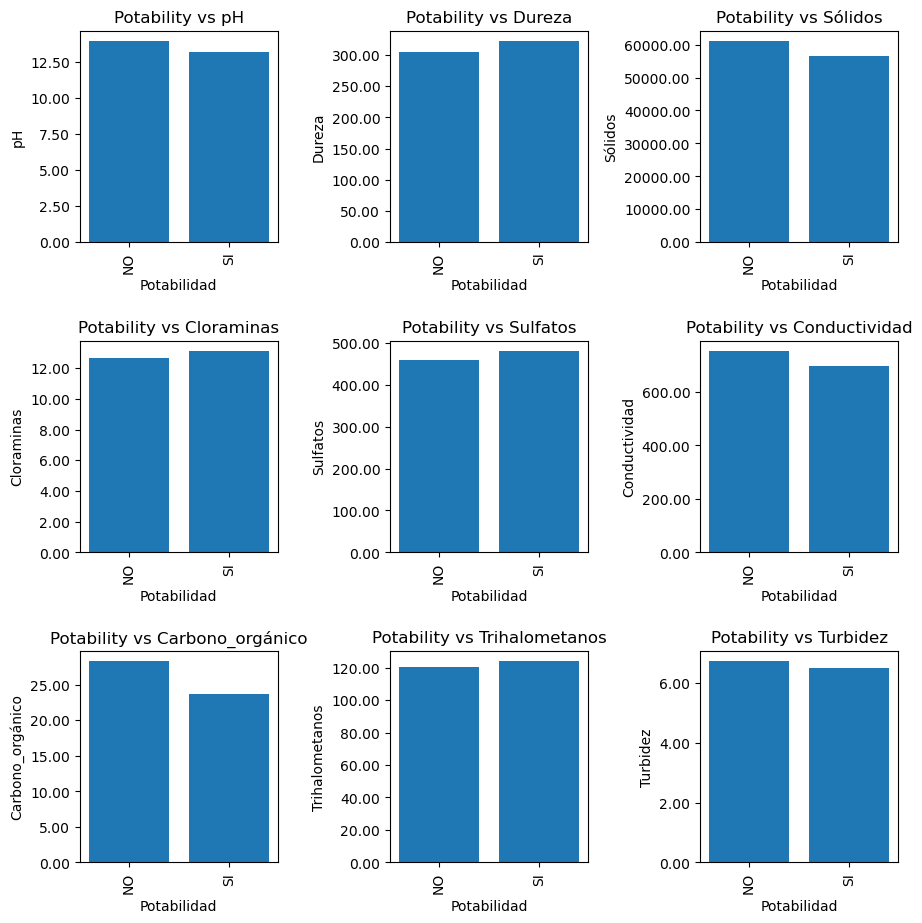

In [10]:
# ["pH", "Sólidos", "Cloraminas", "Sulfatos", "Conductividad", "Trihalometanos", "Turbidez"]

# Ensure inline display of plots in Jupyter notebooks
%matplotlib inline

# Drop the 'Potabilidad' column from the DataFrame and use it as y_data (target variable)
x_data = df_raw.drop(['Potabilidad'], axis=1)
y_data = df_raw['Potabilidad']

# Create subplots with a 3x3 grid and set the figure size
figure2, axis2 = plt.subplots(3, 3, figsize=(10, 10))
# Flatten the axis array for easier iteration
flattenedAxis2 = axis2.flatten()
# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.8)
# Set padding for the entire layout
plt.tight_layout(pad=5.0)

# Initialize counter for subplot index
i = 0
# Round the values in x_data to 2 decimal places
x_data = x_data.round(2)

# Iterate through each column in x_data
for (columnName, columnData) in x_data.items(): 
    # Set the title of each subplot
    flattenedAxis2[i].set_title('Potability vs ' + columnName)
    # Create a bar plot for each column against the 'Potabilidad' values
    flattenedAxis2[i].bar(y_data, columnData)
    # Set the x-axis label to 'Potabilidad'
    flattenedAxis2[i].set_xlabel("Potabilidad")
    # Set the y-axis label to the column name
    flattenedAxis2[i].set_ylabel(columnName)
    # Set the scale of the y-axis to linear
    flattenedAxis2[i].set_yscale('linear')
    # Rotate the x-axis labels by 90 degrees
    flattenedAxis2[i].tick_params(axis='x', labelrotation=90)
    # Format the y-axis labels to 2 decimal places
    flattenedAxis2[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    # Increment the subplot index
    i += 1

# Display the plots
plt.show()

From the graphs we can interpret that:

* `Trihalomethanes` is the variable with the least variability between the **YES** and **NO** classes of `Potability`, which suggests that it is very likely that the model determines it as a variable of little importance.
* The variables `Carbon`, `Conductivity`, `Sulfates` and `Hardness` have high variability, which suggests that it is very likely that the model determines them as important.
* Although 'Chloramines' has variability, it is very little, this may affect its importance compared to the model.

We see that some data are not described to us, apparently they are still interpreted as non-numeric, therefore we should make them numerical. Let's first look at the data type with `data.dtypes`:

In [11]:
df_raw.dtypes

pH                  float64
Dureza              float64
Sólidos             float64
Cloraminas          float64
Sulfatos            float64
Conductividad       float64
Carbono_orgánico    float64
Trihalometanos      float64
Turbidez            float64
Potabilidad          object
dtype: object

To measure the correlation only, let's proceed to convert the categorical and object type variables to numeric object type columns. For that we will use `pd.to_numeric(<column>)`, we will save this result in a temporary dataframe `df_raw_for_correlation` for exclusive use of correlation metrics:

In [12]:
df_raw_for_correlation = pd.get_dummies(df_raw, columns = ["Potabilidad"])
df_raw_for_correlation.head()

,pH,Dureza,Sólidos,Cloraminas,Sulfatos,Conductividad,Carbono_orgánico,Trihalometanos,Turbidez,Potabilidad_NO,Potabilidad_SI
0,NaN,204.89,20791.32,7.30,368.52,564.31,10.38,86.99,2.96,1,0
1,3.72,129.42,18630.06,6.64,NaN,592.89,15.18,56.33,4.50,1,0
2,8.10,224.24,19909.54,9.28,NaN,418.61,16.87,66.42,3.06,1,0
3,8.32,214.37,22018.42,8.06,356.89,363.27,18.44,100.34,4.63,1,0
4,9.09,181.10,17978.99,6.55,310.14,398.41,11.56,32.00,4.08,1,0


Now it is necessary to identify if there is non-relevant data and if so, know what these are. In this case Pandas can easily help us obtain the correlation matrix of the dataframe we are working with:

In [13]:
df_raw_correlation_matrix = df_raw_for_correlation.corr(numeric_only = True) #use numeric values only!
df_raw_correlation_matrix

,pH,Dureza,Sólidos,Cloraminas,Sulfatos,Conductividad,Carbono_orgánico,Trihalometanos,Turbidez,Potabilidad_NO,Potabilidad_SI
pH,1.000000,0.082086,-0.089271,-0.034247,0.018271,0.018606,0.043529,0.003446,-0.038985,0.003555,-0.003555
Dureza,0.082086,1.000000,-0.046900,-0.030040,-0.106923,-0.023915,0.003601,-0.013015,-0.014487,0.013835,-0.013835
Sólidos,-0.089271,-0.046900,1.000000,-0.070211,-0.171804,0.013831,0.010246,-0.009147,0.019551,-0.033743,0.033743
Cloraminas,-0.034247,-0.030040,-0.070211,1.000000,0.027307,-0.020465,-0.012678,0.017084,0.002334,-0.023755,0.023755
Sulfatos,0.018271,-0.106923,-0.171804,0.027307,1.000000,-0.016123,0.030830,-0.030276,-0.011155,0.023577,-0.023577
Conductividad,0.018606,-0.023915,0.013831,-0.020465,-0.016123,1.000000,0.020965,0.001289,0.005694,0.008128,-0.008128
Carbono_orgánico,0.043529,0.003601,0.010246,-0.012678,0.030830,0.020965,1.000000,-0.013296,-0.027342,0.029985,-0.029985
Trihalometanos,0.003446,-0.013015,-0.009147,0.017084,-0.030276,0.001289,-0.013296,1.000000,-0.022224,-0.007127,0.007127
Turbidez,-0.038985,-0.014487,0.019551,0.002334,-0.011155,0.005694,-0.027342,-0.022224,1.000000,-0.001562,0.001562
Potabilidad_NO,0.003555,0.013835,-0.033743,-0.023755,0.023577,0.008128,0.029985,-0.007127,-0.001562,1.000000,-1.000000


In order to better understand this correlation we are going to use the `heatmap` function of the [seaborn](https://seaborn.pydata.org/examples/many_pairwise_correlations.html) library which will show us the variables that are mostly correlated as the hot points of the matrix:


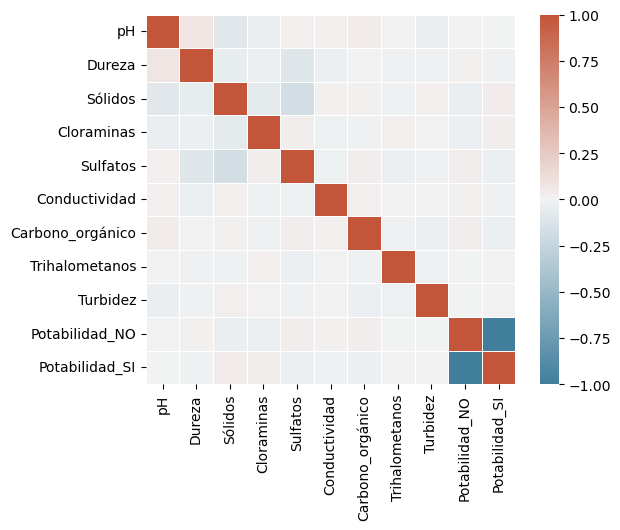

In [14]:
# Generate a custom diverging colormap
cmap = sn.diverging_palette(230, 20, as_cmap=True)
sn.heatmap(df_raw_correlation_matrix, cmap=cmap, square=True, linewidths=.5, center=0) # add , annot=True for annotations 
plt.show()

From the correlation matrix we can conclude for now that:
* Potability is negatively related to sulfates, conductivity, organic carbon, hardness and pH
* Potability is positively related to chlorine and solids
* Solids are visibly and negatively related to sulfates and pH

Before training any machine learning model, it is important to ensure that the data used does not contain errors, such as missing or duplicate data. For this it is advisable to use a new variable, in this case `data`, which we will use to store a modified data set:

In [15]:
data = df_raw.copy()

#### Verification of missing data:
Now we will check if the dataframe contains missing values, and we will save this information:

In [16]:
absentSum = data.isna().sum()
columIndexesWithAbsentValues = [i for i,v in enumerate(absentSum) if v > 0]
print(absentSum)
print("\nColumns with absent values: " + str(columIndexesWithAbsentValues))

pH                  491
Dureza                0
Sólidos               0
Cloraminas            0
Sulfatos            781
Conductividad         0
Carbono_orgánico      0
Trihalometanos      162
Turbidez              0
Potabilidad           0
dtype: int64

Columns with absent values: [0, 4, 7]


Given the significant amount of missing data compared to the amount of total data, deleting data may not be an option in this case. We will have to use a data imputation based approach in order to solve this problem.

#### Duplicate data check:

Now we will check if the dataframe contains duplicate values:

In [17]:
duplicatedSum = data.duplicated().sum()
duplicatedSum

0

Data does not contain duplicates

### 2. Data division

We will proceed to separate the training data from the test data. We will use 80% of the data for training and the remaining 20% ​​for testing:

In [18]:
train, test = train_test_split(data, test_size=0.2, random_state=77)
train.head()

,pH,Dureza,Sólidos,Cloraminas,Sulfatos,Conductividad,Carbono_orgánico,Trihalometanos,Turbidez,Potabilidad
3126,6.67,155.71,30610.05,8.17,337.17,425.69,15.10,79.78,4.90,SI
3147,6.26,130.37,9734.68,10.28,320.36,399.35,10.85,43.42,3.93,SI
2844,6.66,182.39,16828.88,7.07,355.90,434.66,16.62,69.41,3.97,SI
1916,8.02,255.26,30854.83,8.76,NaN,442.50,11.09,93.27,5.32,SI
1053,8.92,207.52,13291.92,8.56,357.94,468.54,15.69,107.28,4.08,NO


Furthermore, we will separate the target variable `Potability` from the descriptor variables:

In [19]:
x_train = train.drop(['Potabilidad'],axis=1)
y_train = train['Potabilidad']

We will do the same with the test data set:

In [20]:
x_test = test.drop(['Potabilidad'],axis=1)
y_test = test['Potabilidad']

Let's save the `x_train` columns for rebuilding the dataset later:

In [21]:
data_columns = x_train.columns


### 3. Data cleaning and preparation

#### At this point we will create a `Pipeline` which will sequence the execution of each data processing step until we obtain a model.

Cleaning and preparing the data, justifying the decisions made based on the results obtained in the previous step.


#### Elimination of irrelevant variables

We will include an IrelevantVariablesRemover within the pipeline, although no variables of little relevance to the model have been found so far.

In [22]:
irelevants = []

def irelevantVariablesRemover(df, irrelevant_variables_list_names):
    df = pd.DataFrame(df)
    return df.drop(irrelevant_variables_list_names, axis=1)

irelevant_remover_tranformer = FunctionTransformer(irelevantVariablesRemover, 
                                                   kw_args={ 
                                                       'irrelevant_variables_list_names':irelevants
                                                   })
    
irelevant_remover_tranformer

FunctionTransformer(func=<function irelevantVariablesRemover at 0x15d4c7420>,
                    kw_args={'irrelevant_variables_list_names': []})

#### Duplicate data processing

We will include a DuplicatesRemover within the pipeline, even though the data set does not contain duplicate data.

In [23]:
def removeDuplicates(df):
    df = pd.DataFrame(df)
    return df.drop_duplicates()

duplicates_remover_transformer = FunctionTransformer(removeDuplicates)

#### Handling of missing data

Since the dataset contains for `pH` 491 missing data, for `Sulfates` 781 missing data and for `Trihalomethanes` 162 missing data, we will have to use an approach based on data imputation to be able to solve this problem. For this we will use a `SimpleImputer` with `median` strategy since the data contains many extremes or _outliers_ and the `mean` mean is not useful in this case because it can be affected by these outliers. Since this type of imputation applies only to numerical values, we must use a `ColumnTransformer` to assign which columns we should impute which will use the variable `columIndexesWithAbsentValues` that we created earlier to save the columns that have missing values. Also for categorical columns We will create one by default in case we need it:


In [24]:
imputer_tranformer = DataImputerTransformer(colums_indexes_with_absent_values=columIndexesWithAbsentValues)
imputer_tranformer

DataImputerTransformer(colums_indexes_with_absent_values=[0, 4, 7])

#### Categorical variable transformation

We will include a **OneHot** encoding within the pipeline using an object of the class:

In [25]:
encoder = OneHotEncoder()

#### Standardization of numerical variables

We introduce a scaler as part of the data standardization step

In [26]:
scaler = StandardScaler()

We apply the transformation to our data and reconstruct the data set based on the previously saved columns:

In [27]:
def scalerEncoderTranformer(df, columns):
    df = pd.DataFrame(df, columns=columns)
    numeric_features = []  
    categorical_features = [] 

    for indexColumn in range( df.shape[1]):
        columnName = df.columns[indexColumn]
        if (df[columnName].dtype.name == 'object'): 
            categorical_features.append(indexColumn)
        else:
            numeric_features.append(indexColumn)

    return ColumnTransformer(
        transformers=[
            ("numeric", scaler, numeric_features),
            ("categorical", encoder, categorical_features)
        ],
        remainder='passthrough'
    ).fit_transform(df)

scaler_encoder_transformer = FunctionTransformer(scalerEncoderTranformer, kw_args={'columns': data_columns})

scaler_encoder_transformer


FunctionTransformer(func=<function scalerEncoderTranformer at 0x15d544f40>,
                    kw_args={'columns': Index(['pH', 'Dureza', 'Sólidos', 'Cloraminas', 'Sulfatos', 'Conductividad',
       'Carbono_orgánico', 'Trihalometanos', 'Turbidez'],
      dtype='object')})

#### Pipeline creation

We already have the transformers we need ready. Now we need to define the order in which they will be invoked, for this we will create a list of pairs (name, transformer) that will define the steps to follow in processing the data:

In [28]:
steps = [
    ("irelevants_remover", irelevant_remover_tranformer),
    ("duplicates_remover", duplicates_remover_transformer),
    ("imputer",imputer_tranformer),
    ("transformer",scaler_encoder_transformer), 
]

Now we will create an object of the `Pipeline()` class to perform the preprocessing, and we will assign the steps to it:

In [29]:
pipeline = Pipeline(steps)
pipeline

Pipeline(steps=[('irelevants_remover',
                 FunctionTransformer(func=<function irelevantVariablesRemover at 0x15d4c7420>,
                                     kw_args={'irrelevant_variables_list_names': []})),
                ('duplicates_remover',
                 FunctionTransformer(func=<function removeDuplicates at 0x15d5440e0>)),
                ('imputer',
                 DataImputerTransformer(colums_indexes_with_absent_values=[0, 4,
                                                                           7])),
                ('transformer',
                 FunctionTransformer(func=<function scalerEncoderTranformer at 0x15d544f40>,
                                     kw_args={'columns': Index(['pH', 'Dureza', 'Sólidos', 'Cloraminas', 'Sulfatos', 'Conductividad',
       'Carbono_orgánico', 'Trihalometanos', 'Turbidez'],
      dtype='object')}))])

Our Pipeline looks great 🤩!


Now, we are going to use the pre-processing pipeline to transform the training data set using the `fit_transform()` function.  It will also be necessary to rebuild the dataframe using the `data_columns` object:

In [30]:
x_train_transformed = pipeline.fit_transform(x_train)
x_train_transformed

array([[-0.28662453,  0.09900941,  0.85788928, ...,  0.00307122,
         0.24874044,  1.18622635],
       [-0.56831902, -0.37007373, -1.45882654, ..., -0.32254573,
        -1.04478001, -0.04551541],
       [-0.29349513,  0.62167016,  0.19715377, ...,  0.113959  ,
         0.71136422,  0.00527806],
       ...,
       [ 0.28363503,  2.05626648,  0.12706611, ..., -1.56073077,
         1.96531816,  0.34813402],
       [ 1.76081343,  1.47667952, -0.79108226, ..., -0.40388816,
        -0.5578076 , -0.9851947 ],
       [-1.52333202,  0.88397721, -1.31673973, ...,  1.33335369,
         0.56831608,  1.40209862]])

### 4. Construction of a decision tree model

We have our pipeline ready, now we can build our model based on decision trees. But first let's proceed to search for hyperparameters:

#### Searching for hyperparameters with a pipeline

With the modified data set, we will create an object of the `DecisionTreeClassifier()` class that will be our base model to perform the exhaustive hyperparameter search:

In [31]:
decision_tree = DecisionTreeClassifier(class_weight='balanced', random_state=77)

Now we will declare `param_grid` with the following parameters to perform the search:
* `criterion`: the purity criterion, which determines the quality of a split. We will use two of the most popular: entropy and GINI.
* `max_depth`: The maximum depth of the tree. This hyperparameter is used to control the complexity of the model.
* `min_samples_split`: minimum number of data needed in a node to be able to define a split.

In [32]:
param_grid = {
                'criterion':['gini', 'entropy'],
                'max_depth':[4,6,8,10,12],
                'min_samples_split':[3, 4, 5]
            }

We will then define an object of class `KFold()` to perform cross-validation with 10 subsets of data:

In [33]:
kfold = KFold(n_splits=10, shuffle=True, random_state=77)

Finally, we will define the search with an object of the `GridSearchCV()` class using the `decision_tree` model, the `param_grid` search space and the `kfold` cross-validation technique:

In [34]:
grid = GridSearchCV(decision_tree, param_grid, cv=kfold, n_jobs=-1)

We will search on the training set modified with the pipeline, defined by the variables `x_train_transformed` and `y_train`:

In [35]:
grid.fit(x_train_transformed, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=77, shuffle=True),
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=77),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10, 12],
                         'min_samples_split': [3, 4, 5]})

Let's look at the best values ​​of the hyperparameters obtained:

In [36]:
print("Mejores parámetros: {}".format(grid.best_params_))

Mejores parámetros: {'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 5}


As a result the model uses **gini** purity criteria, maximum tree depth is **4**, and a minimum of **5** data to perform a split. We will store the best model:

In [37]:
mejor_modelo = grid.best_estimator_

#### 🎉What are the most significant variables according to the best model based on decision trees?

We will proceed to estimate the most significant variables for the model:


In [38]:
importance = mejor_modelo.feature_importances_
importance_df = pd.DataFrame(data={'Variable':data_columns, 'Importance':importance})
importance_df.sort_values('Importance', ascending=False)

,Variable,Importance
0,pH,0.516443
1,Dureza,0.194801
3,Cloraminas,0.082310
5,Conductividad,0.054696
8,Turbidez,0.047497
2,Sólidos,0.038191
4,Sulfatos,0.037692
6,Carbono_orgánico,0.028371
7,Trihalometanos,0.000000


Some conclusions that can be drawn from these results are:

* **Importance of variables:** The model assigns high importance to the variables `pH`, `Hardness` and `Chloramines`, suggesting that these characteristics are crucial in determining whether water is drinkable or not. These variables are likely to have a strong influence on model classification decisions.
* **Variables of minor importance:** The variables `Turbidity`, `Solids`, `Sulfates` and `Organic_carbon` also have some importance, although they are less relevant than the three main ones. Although their importance is less, these variables still contribute to the classification process.
* **Unimportant variable:** The model assigns an importance of zero to the variable `Trihalomethanes`. This means that, according to the model, this variable has no impact on the final classification of whether the water is drinkable or not. It may be an indication that this characteristic does not provide useful information for the model or that it is highly correlated with other variables. Which suggests we could remove it and it wouldn't affect the result.

### 5. Evaluation of the decision tree model

Let's separate the target variable from the descriptor variables in the test set:

In [39]:
x_test = test.drop(['Potabilidad'],axis=1)
y_test = test['Potabilidad']

With the information available from the training set, we will use the pipeline's `transform()` function to transform the test set:

In [40]:
x_test_transformed = pipeline.transform(x_test)
x_test_transformed

array([[ 0.07185792,  1.04777996,  1.37259307, ..., -1.66465662,
        -2.06905093, -0.75986217],
       [ 1.85538172,  0.10127987, -0.98863516, ...,  0.41316484,
        -1.23243318,  0.73248195],
       [ 0.24234181, -0.03628815, -1.64217827, ..., -0.6561503 ,
         1.12423653, -0.16025962],
       ...,
       [ 1.4029437 , -1.89834558, -1.1524882 , ...,  1.73056507,
        -1.81865477, -0.57331916],
       [-0.34779474,  0.42785321, -0.61108785, ...,  2.77662612,
        -1.20297481,  0.93234947],
       [-0.02977671,  0.34855402, -0.74503615, ..., -0.62779772,
         0.95632382,  0.75913095]])

It's time to make predictions! 🔮:

In [41]:
y_pred = mejor_modelo.predict(x_test_transformed)

Now let's look at the results of our predictions in the confusion matrix

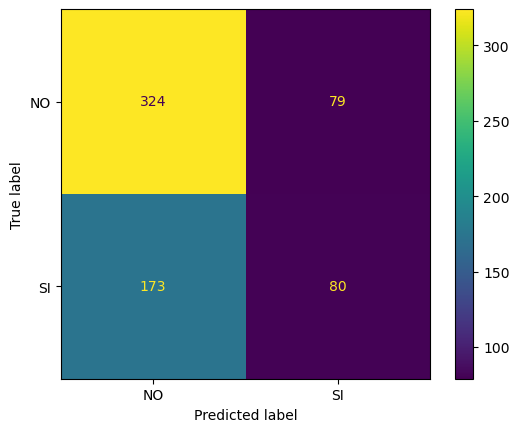

In [42]:
ConfusionMatrixDisplay.from_estimator(mejor_modelo, x_test_transformed, y_test)  
plt.show()

##### 🎉 From the confusion matrix we can say that:

* **True Positives (TP):** There are 80 water samples that were correctly classified as **YES** `Potable` by the model.
* **False Positives (FP):** There are 79 water samples that were incorrectly classified as **YES** `Potable` by the model when in reality they were **NO** not `Potable`.
* **True Negatives (TN):** There are 324 water samples that were correctly classified as **NOT** not `Potable` by the model.
* **False Negatives (FN):** There are 173 water samples that were incorrectly classified as **NO** not 'Potable' by the model when in reality they were **YES** 'Potable'.

The model correctly classified 80 drinking water samples **YES** and 324 non-potable water samples **NO**. However, it made errors in classifying 79 non-potable water samples as potable and 173 potable water samples as non-potable.

##### Now let's look at the classification report:

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          NO       0.65      0.80      0.72       403
          SI       0.50      0.32      0.39       253

    accuracy                           0.62       656
   macro avg       0.58      0.56      0.55       656
weighted avg       0.59      0.62      0.59       656



Based on this table, the model appears to have moderate performance in classifying water as potable **YES**, with a precision of 50% but a relatively low recall of 32%. The F1-score of 39% reflects a balance between precision and recall. This suggests that the model may need to improve its ability to correctly identify **SI** positive cases without compromising accuracy too much. The overall accuracy of the model is 62%, meaning it gets 62% of the predictions right overall. Which means that it is advisable to adjust the model for better results.

Now let's see what our tree looks like:

[Text(0.45689655172413796, 0.9, 'Dureza <= -1.317\ngini = 0.5\nsamples = 2620\nvalue = [1310.0, 1310.0]\nclass = NO'),
 Text(0.1896551724137931, 0.7, 'pH <= -0.235\ngini = 0.449\nsamples = 227\nvalue = [82.953, 161.034]\nclass = SI'),
 Text(0.06896551724137931, 0.5, 'Conductividad <= -1.476\ngini = 0.48\nsamples = 80\nvalue = [45.994, 30.673]\nclass = NO'),
 Text(0.034482758620689655, 0.3, 'gini = 0.0\nsamples = 7\nvalue = [0.0, 8.946]\nclass = SI'),
 Text(0.10344827586206896, 0.3, 'Sólidos <= -0.013\ngini = 0.436\nsamples = 73\nvalue = [45.994, 21.727]\nclass = NO'),
 Text(0.06896551724137931, 0.1, 'gini = 0.103\nsamples = 28\nvalue = [22.176, 1.278]\nclass = NO'),
 Text(0.13793103448275862, 0.1, 'gini = 0.497\nsamples = 45\nvalue = [23.818, 20.449]\nclass = NO'),
 Text(0.3103448275862069, 0.5, 'Cloraminas <= 0.614\ngini = 0.344\nsamples = 147\nvalue = [36.959, 130.361]\nclass = SI'),
 Text(0.2413793103448276, 0.3, 'Sulfatos <= -1.068\ngini = 0.239\nsamples = 95\nvalue = [15.605, 97.1

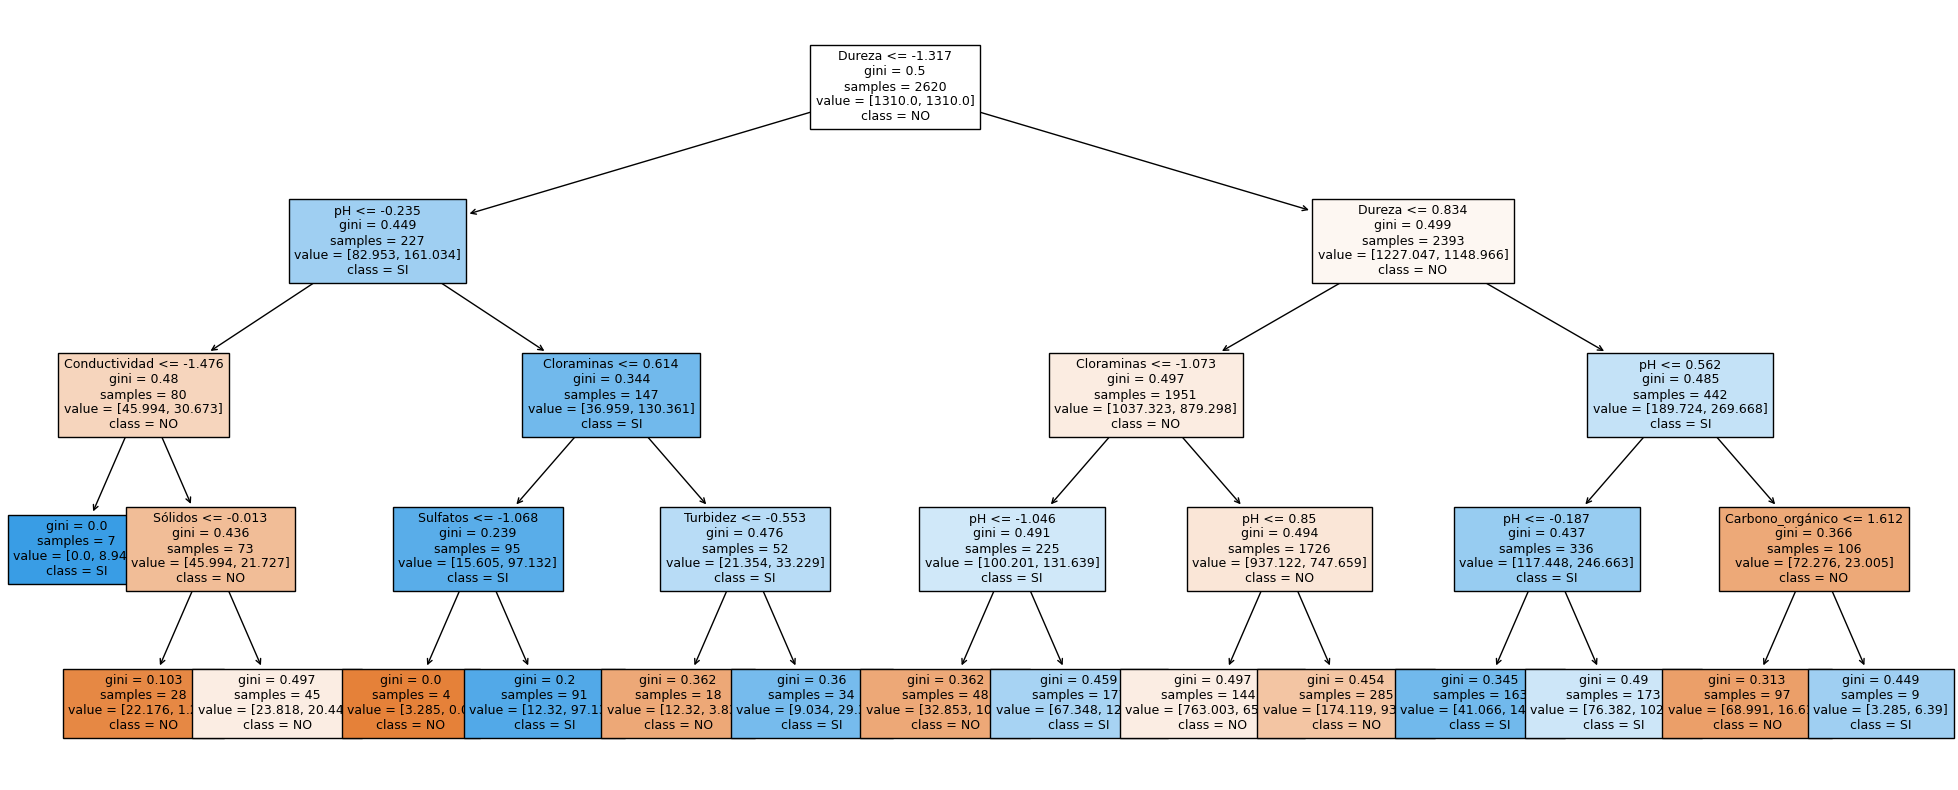

In [44]:
plt.figure(figsize=(25,10))
# tree.plot_tree(mejor_modelo, feature_names=x_train.columns, class_names=['NO','SI'], filled=True, fontsize=9)
tree.plot_tree(mejor_modelo, feature_names=list(x_train.columns), class_names=['NO','SI'], filled=True, fontsize=9)

#### Generation of rules to determine water potability

Let's see what it looks like for a depth of 3 levels. The printed rules will show how the model makes decisions to determine whether or not the water is safe to drink based on the characteristics provided in your data. These rules will be in text form and will help you understand the tree's decision process.

|--- Dureza <= -1.32
|   |--- pH <= -0.24
|   |   |--- Conductividad <= -1.48
|   |   |   |--- class: SI
|   |   |--- Conductividad >  -1.48
|   |   |   |--- class: NO
|   |--- pH >  -0.24
|   |   |--- Cloraminas <= 0.61
|   |   |   |--- class: SI
|   |   |--- Cloraminas >  0.61
|   |   |   |--- class: SI
|--- Dureza >  -1.32
|   |--- Dureza <= 0.83
|   |   |--- Cloraminas <= -1.07
|   |   |   |--- class: SI
|   |   |--- Cloraminas >  -1.07
|   |   |   |--- class: NO
|   |--- Dureza >  0.83
|   |   |--- pH <= 0.56
|   |   |   |--- class: SI
|   |   |--- pH >  0.56
|   |   |   |--- class: NO



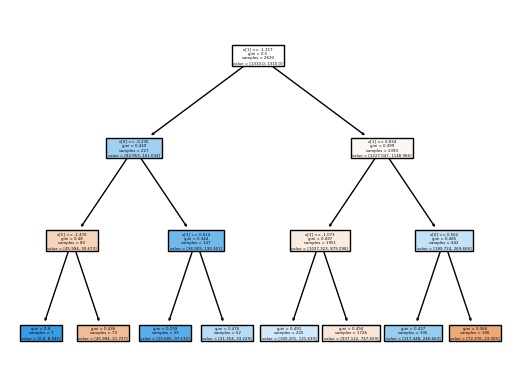

In [45]:
decision_tree = DecisionTreeClassifier(max_depth=3, class_weight='balanced', random_state=77)
modelo = decision_tree.fit(x_train_transformed, y_train)
tree.plot_tree(modelo, filled=True)
plt.rcParams['figure.figsize'] = [25,10]
# Extrae las reglas del árbol de decisión.
tree_rules = export_text(decision_tree, feature_names=list(data_columns))
# Imprime las reglas.
print(tree_rules)

### 6. Building a model using the K-nearest neighbors algorithm

For this model we will try to find the best value of _k_, represented by the `n_neighbors` parameter of `KNeighborsClassifier`, using a validation curve:

In [46]:
k_values =  [1, 2, 3, 4, 5]
k_values

[1, 2, 3, 4, 5]

We are going to use the validation_curve() function to make a validation curve with the _k_ parameter. We will use the training set represented with the variables `x_train_transformed` and `y_train`, modifying the n_neighbors parameter of the `KNeighborsClassifier` model. We will also use a 10-subset cross-validation, storing the accuracy values ​​in the `train_scores` and `val_scores` variables:

In [47]:
train_scores, val_scores = validation_curve(
                                            estimator=KNeighborsClassifier(),
                                            X=x_train_transformed,
                                            y=y_train,
                                            param_name='n_neighbors',
                                            param_range=k_values,
                                            scoring='accuracy',
                                            cv=10
                                           )

Now we will proceed to graph the values ​​of the mean and standard deviation of the training and validation sets:

In [48]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

Now using the values ​​generated above let's find the best value of _k_, in this case the best index of the list of values:

In [49]:
mejor_indice = np.argmax(val_mean)
mejor_indice

1

Which corresponds to the value:

In [50]:
mejor_k = k_values[mejor_indice]
mejor_k

2

Let's compare these values ​​with a search using GridSearchCV:


In [51]:
estimator = KNeighborsClassifier()
grid = dict(n_neighbors=k_values)

grid_search_KNN = GridSearchCV(estimator, grid, cv=10, scoring='accuracy', return_train_score=False)
grid_search_KNN.fit(x_train_transformed, y_train)

print(grid_search_KNN.best_index_)
print(grid_search_KNN.best_params_)
print(grid_search_KNN.best_estimator_)

1
{'n_neighbors': 2}
KNeighborsClassifier(n_neighbors=2)


We can see that with GridSearchCV the results are similar. Now that we know what the improvement _k_ is, let's use it to generate the best model:


In [52]:
mejor_modelo = KNeighborsClassifier(n_neighbors=mejor_k).fit(x_train_transformed, y_train)
mejor_modelo

KNeighborsClassifier(n_neighbors=2)

### 7. Model evaluation using the K-nearest neighbors algorithm

It's time to make predictions! 🔮

In [53]:
y_pred = mejor_modelo.predict(x_test_transformed)

Now let's look at the results of our predictions in the confusion matrix

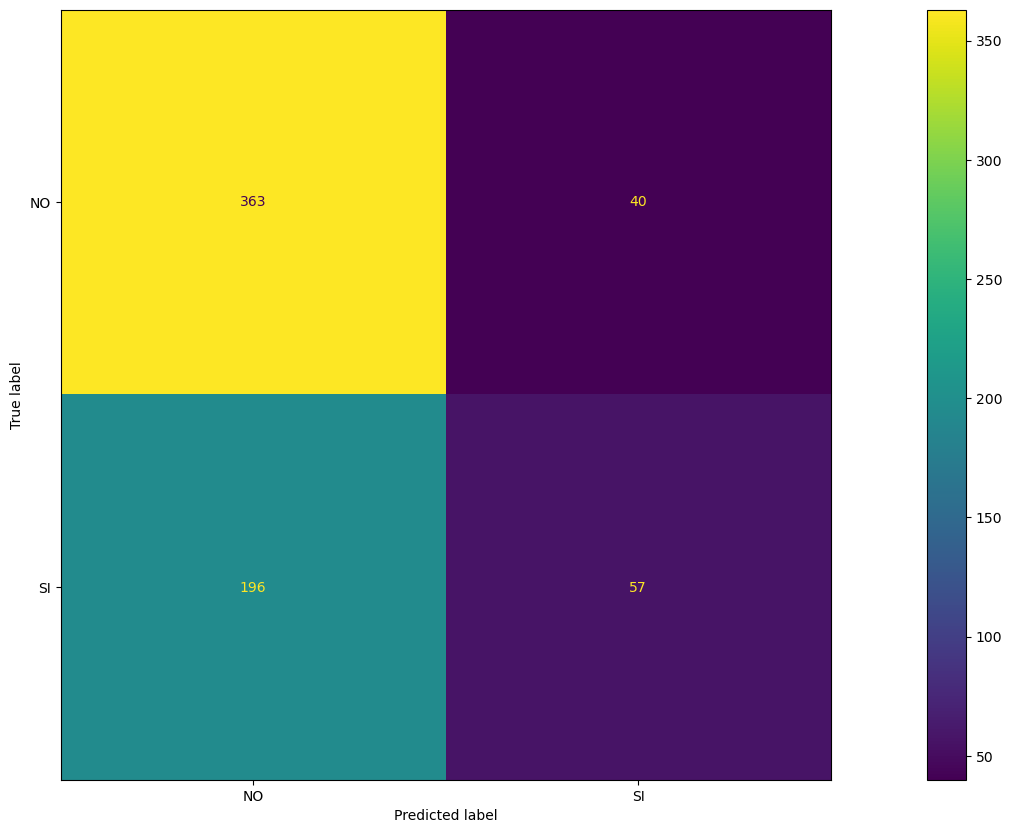

In [54]:
ConfusionMatrixDisplay.from_estimator(mejor_modelo, x_test_transformed, y_test) 
plt.show()

##### 🎉 From the confusion matrix we can conclude that:

* **True Positives (TP):** There are 57 water samples that were correctly classified as **YES** `Potable` by the model.
* **False Positives (FP):** There are 40 water samples that were incorrectly classified as **YES** `Potable` by the model when in reality they were **NO** not `Potable`.
* **True Negatives (TN):** There are 363 water samples that were correctly classified as **NOT** not `Potable` by the model.
* **False Negatives (FN):** There are 196 water samples that were incorrectly classified as **NO** not 'Potable' by the model when in reality they were **YES** 'Potable'.

The model correctly classified 57 drinking water samples **YES** and 363 non-potable water samples **NO**. However, it made errors in classifying 40 non-potable water samples as potable and 196 potable water samples as non-potable.

##### Now let's look at the classification report:

In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          NO       0.65      0.90      0.75       403
          SI       0.59      0.23      0.33       253

    accuracy                           0.64       656
   macro avg       0.62      0.56      0.54       656
weighted avg       0.63      0.64      0.59       656



From the previous table we can say that the model seems to have good performance in the **NO** non-`Potable` class, with high precision and recall. However, its performance in the **SI** `Potable` class is less satisfactory, with lower precision and very low recall. The overall accuracy metric of the model is 64%, indicating that the model has moderate performance overall.

### 8. Comparison of metrics



|            | Tree NO | KNN NO | SI Tree | KNN SI |
|------------|----------------|-----------|----------------|-----------|
| precision  |     0.65       |   0.65    |     0.50       |   0.59    |
| recall     |     0.80       |   0.90    |     0.32       |   0.23    |
| f1-score   |     0.72       |   0.75    |     0.39       |   0.33    |

|            | Tree | KNN |
|------------|----------------|-----------|
| accuracy   |     0.62       |   0.64    |


Based on the previous comparative table, the following two questions which conclude that:


##### Do you think the performance of the models is adequate? If not, how could the results be improved?

This is relative, since it depends on the context where it is developed, we can observe a significant imbalance in the results of the predictions, which could be useful depending on the context where the model is being used. If this were used to measure the quality of water in a polluted river, it would most likely fit quite well; if used for a drinking water source, it could be discriminatory. But because water is for human consumption, it is good that it has a fairly high recall that favors the **NO** option since otherwise the model would be putting the lives of the actors who accept at risk. its result.  The model has acceptable precision for the non-potable **NO** class, but a relatively low recall for the potable **SI** class. This suggests that the model tends to identify non-potable water samples well, but could be missing some drinking water samples. If accurate detection of drinking water is critical, work could be done to improve the recall for the **SI** class. If you want to find a balance between both metrics, you could adjust the model's decision threshold to optimize the F1-Score. You may consider adding new relevant features or transforming existing ones to better capture useful information from the data set. To reduce the imbalance, increasing the data for the **SI** class would be recommended.

##### If the two models provide similar results in terms of performance metrics, which one would you select taking into account the context of the problem?

Although KNN performed better, for the problem of determining the potability of water, in general, it might be a good idea to start with the Decision Tree due to its interpretability and ease of visualization. Decision trees can help understand which characteristics are most important in determining whether water is drinkable or not, which can be valuable in the context of water quality.